# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: The first dimension of PCA will compose a new feature by using the old features and maximize the variance dimension, so according to the variances of each original feature values, the first dimension is likely to be composed by "Fresh" and "Grocery".
In ICA dimesions, any two vectors vertical, $v_i \wedge v_j = 0$, so we can have independent features. After transformation if in one dimension the variance is small

###PCA

In [2]:
# Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print data.columns
print pca.components_
print pca.explained_variance_ratio_
print data.var()

Index([u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper',
       u'Delicatessen'],
      dtype='object')
[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]
Fresh               1.599549e+08
Milk                5.446997e+07
Grocery             9.031010e+07
Frozen              2.356785e+07
Detergents_Paper    2.273244e+07
Delicatessen        7.952997e+06
dtype: float64


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: It begins to drop a lot at the third dimension. I will choos the first two since it will cover about 0.86 of the variance.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: In original data we have six features: Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicatessen, but we can compose them by using PCA and use new components to represent the data. The first feature value in new dataset is determined by the first row of the components matrix. So we can see the first new feature is mainly composed by Fresh. The second is mainly composed by Milk, Grocery and Detergent paper.

If we multiply our data set with only the first two rows of the components matrix, we can have a new dataset with only two principle features and kind of maintain the information. We can then visualize the customer since we only have two dimensions now.

The new components may not have exactly meaning corresponding to real world features like before, but it helps us the reduce noices and unsignificant features(reduce feature demension), which help us to train a classifier or cluster our customers.




###ICA

In [21]:
# Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

data_center = data - data.mean()
data_center /= data_center.std(axis=0)

ica = FastICA(n_components=6, random_state = 0)
ica.fit(data_center)

# Print the independent components
print "[u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper', u'Delicatessen']"
print ica.components_

[u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper', u'Delicatessen']
[[ 0.00260045 -0.01305746  0.06431417  0.00176704 -0.00790475 -0.00473342]
 [ 0.00367038 -0.01677436 -0.11314042  0.00712345  0.13439745  0.01594585]
 [-0.00189744 -0.07287525  0.05450359  0.00183477 -0.01465023  0.0172135 ]
 [-0.05030326  0.00640234  0.00648235  0.00325456 -0.01042646  0.00291546]
 [-0.0048644  -0.0016145  -0.00553501 -0.00242778  0.00230922  0.05096183]
 [ 0.01093164  0.00104722 -0.00730628 -0.05412076  0.0025728   0.01688358]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: this matrix is the unmixing matrix. By multiply the data matrix from the original data with the unmixing matrix, we can get a new dataset and each new feature is independent with each other. By analysing this matrix, we can know the relationship between each features. Like customers are tend to buy something together.

First vector
- associated: Grocery
- anti-associated: Milk

Second vector
- associated: Detergents_Paper
- anti-associated: Grocery

Third vector
- associated: Grocery
- anti-associated: Milk, Detergents_Paper

Forth vector
- associated: Delicatessen

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer:
K Means advantage:
- if data set is huge, then K-Means most of the times computationally faster. It doesn't need to compute the expectation of each data belongs to each cluster in every iteration, instead only assign each data to one cluster in each iteration.
- could be used as a pre-process method

Disadvatage:
- NP hard, a lot of local maximum
- final results relies on the initial cluster(s)
- Hard to determine K

Gaussian Mixture models advatage:
- Gaussian Mixture Models can be be seen as a generalization of k-means. It can express the uncertainty of one instance belongs to different clusters.

Disadvatage:
- more expensive to compute then K Means because of using EM

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [5]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [6]:
# First we reduce the data to two dimensions using PCA to capture variation

reduced_data = PCA(n_components=2).fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [8]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
from sklearn import mixture
from sklearn.cluster import KMeans
clusters_2 = mixture.GMM(n_components=2)
clusters_3 = mixture.GMM(n_components=3)
#clusters = KMeans(n_clusters=2)
clusters_2.fit(reduced_data)
clusters_3.fit(reduced_data)
print clusters_2
print clusters_3

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [12]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z_2 = clusters_2.predict(np.c_[xx.ravel(), yy.ravel()])
Z_3 = clusters_3.predict(np.c_[xx.ravel(), yy.ravel()])

In [13]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids_2 = clusters_2.means_
centroids_3 = clusters_3.means_
#centroids = clusters.cluster_centers_
print centroids_2
print centroids_3

[[  3308.39301792  -3017.01739698]
 [-10810.23008886   9858.15532401]]
[[-17858.6536729   10050.33930164]
 [  7007.45427668   4294.01360677]
 [   313.48539412  -6497.20521133]]


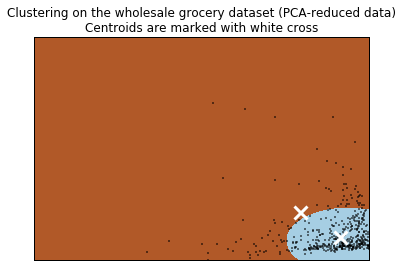

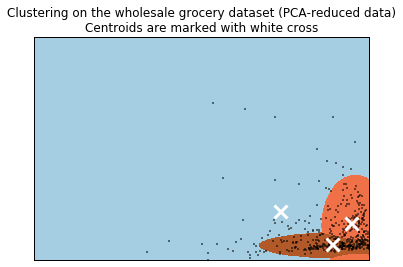

In [14]:
# Put the result into a color plot
def plot(centroids, Z):
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
plot(centroids_2, Z_2)
plot(centroids_3, Z_3)

In [21]:
pca = PCA(n_components=2)
pca.fit(data)
print pca.inverse_transform(centroids_2)
print "***********"
print pca.inverse_transform(centroids_3)

[[  9103.25397456   3839.15728914   5440.84670074   2624.33876372
    1802.56155363   1127.34432737]
 [ 21466.4371414   12191.15139458  16154.15158614   4534.44968674
    6406.92050793   2823.79379221]]
***********
[[ 28328.22426387  13144.43696803  16734.85944039   5604.78171482
    6427.41426808   3314.79434844]
 [  4682.28302764   7161.93556132  10803.26600293   1923.84494628
    4499.7461252    1292.72872954]
 [ 12412.84861354   2407.00399958   2964.18066944   3145.81786215
     509.94568417   1132.66526109]]


**7)** What are the central objects in each cluster? Describe them as customers.

Answer: Central objects are near the centroids, in two clusters, the lower centroid represents a kind of customers who spend less. The upper one represents those customers who spend a lot. The data also shows that customers on the upper cluster tend to spend more on one dimention then the other. Afer inverse the centroids, we can see that one centroid has smaller value in every component than the other one.

In three clusters. We can still get one kind of customer who spend a lot in each component. We can also get one kind of customer who spend less on others but more on Grocery, looks like families. The third cluster spends less on ohters bu more on Fresh and Frozen, may be they're local resteraunts.



###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


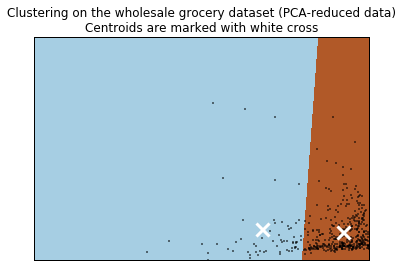

In [112]:
from sklearn import mixture
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=2)
clusters.fit(reduced_data)
print clusters
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Answer: By using PCA to reduce the dimensions to 2, we can visulize the data and see that there's no explicit line here for seperate two clusters. So GMM should be prefered as it uses EM for fiting mixture-of-Gaussian models. It will show a probability of each data belongs to which cluster rather than just gives 0/1. By also running KM with two clusters we can see KM predict the whole right part as one cluster, which makes less sense since it will include customers who spend a lot as well as customers who spend little.

**9)** How would you use that technique to help the company design new experiments?

Answer: Since we can split our customers into two clusters, we may want to know which cluster gives the company larger revenue. So that we can pay more attention to what they need. We may design personalized coupons or promotions to customers from different clusters to see whether we can boost the sales.  If we need to do A/B test, we need to do it on the different clusters and observe the impact seperatly. Because one test may have no effect on the whole dataset but will show different on particular cluster, so that we can target on customers from specific cluster and do new experiments.

**10)** How would you use that data to help you predict future customer needs?

Answer: The company may need to track more behaviors of customers from each cluster. For example small buyers may from the families and we find them tend to come during weekend, we may have some family promotions during that time. For large buyers we can estabish a department to keep track their needs and communicate with them frequently to adjust our purchase.

We can do recommandations based on our new clusters. Instead of learning a recomandation model based on the whole dataset, we can learn two from two different clusters. So we expect to recommand different productions to customers from two different clusters.

One successful recommender system technology is collaborative filtering, which works by matching customer preferences to other customers in making recommendations. So we can run KNN to use similar customers buying behaviour to give a recommendation list to currrent customer. The calculation of KNN is expensive since it needs to calculate the similarity between current customer and all other customers in the dataset. With Clustering , we only need to calculate the the similarity between current customer and the others who are in the same cluster. This will save a lot of time.